In [2]:
import sys

from IPython.core.pylabtools import figsize

from utils import get_intervals

In [3]:
sys.path.append('../')
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# do log-transform on non-zero, scaled and normalized counts
def log_transform(x, cell_counts, scale_factor=10000):
    # we only normalize the counts of cells that have non-zero counts (normalized zero-counts are zero regardless) 
    return np.log((x[x>0] * scale_factor) / cell_counts[x>0])

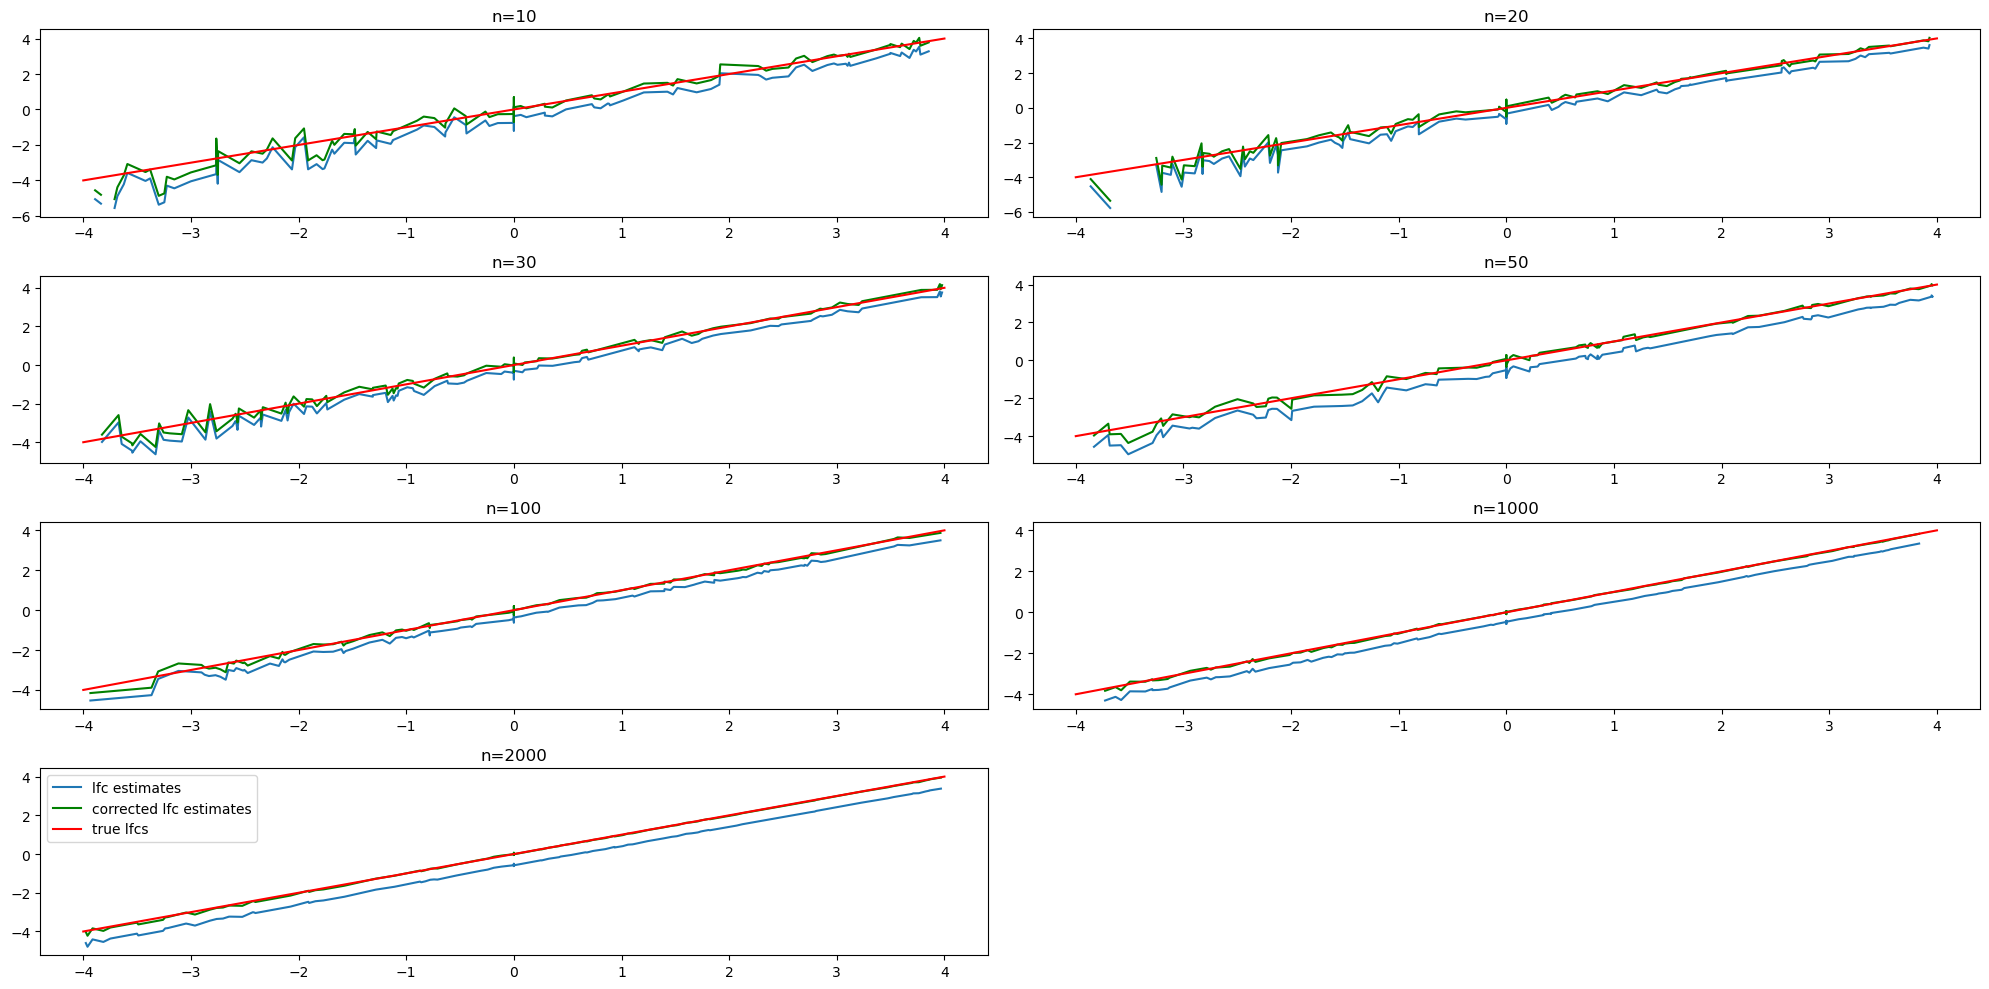

In [7]:
n_list = [10, 20, 30, 50, 100, 1000, 2000]
n_genes = 1000

# variables for plotting
n_rows, n_cols = 4, 2
fig, ax = plt.subplots(n_rows, n_cols, figsize = (20, 10))
row, col = 0, 0

data_folder = "../data_from_NB_parameters_r2_10_p_06/"
for n in n_list:
    folder = f"n_{n}"
    X = pd.read_csv(data_folder + folder + "/control_counts.csv", index_col=0).to_numpy()
    Y = pd.read_csv(data_folder + folder + "/treatment_counts.csv", index_col=0).to_numpy()
    lfcs = pd.read_csv(data_folder + folder + "/lfcs.csv", index_col=0).to_numpy().reshape(-1)
    idx = np.argsort(lfcs)
    
    estimated_lfcs = []
    estimated_corrected_lfcs = []
    
    # sum over the gene axis
    cell_counts_X = X.sum(axis=1)
    cell_counts_Y = Y.sum(axis=1)
    
    for g in range(n_genes):
        x = X[:, g]
        y = Y[:, g]
        lfc = lfcs[g]
        
        x_N_plus = np.sum(x > 0, axis=0)
        x_N_0 = np.sum(x == 0, axis=0)
        # log_x = np.log(x[x>0])
        log_x = log_transform(x, cell_counts_X)
        _, log_mu_x, _ = get_intervals(log_x, x_N_plus, x_N_0, eps=1e-3)
        
        
        y_N_plus = np.sum(y > 0, axis=0)
        y_N_0 = np.sum(y == 0, axis=0)
        # log_y = np.log(y[y>0])
        log_y = log_transform(y, cell_counts_Y)
        _, log_mu_y, _ = get_intervals(log_y, y_N_plus, y_N_0, eps=1e-3)
        
        if log_y.sum() == 0:
            print()
        if log_x.sum() == 0:
            print()
        
        estimated_lfc = log_mu_y - log_mu_x
        estimated_lfcs.append(estimated_lfc)
        estimated_corrected_lfc = estimated_lfc + np.log(np.mean(cell_counts_Y) / np.mean(cell_counts_X))
        estimated_corrected_lfcs.append(estimated_corrected_lfc)
    
    estimated_lfcs = np.array(estimated_lfcs)
    estimated_corrected_lfcs = np.array(estimated_corrected_lfcs)
    
    ax[row, col].plot(lfcs[idx], estimated_lfcs[idx], label='lfc estimates')
    ax[row, col].plot(lfcs[idx], estimated_corrected_lfcs[idx], color='green', label='corrected lfc estimates')
    ax[row, col].set_title(f'n={n}')
    ax[row, col].plot([-4, 4], [-4, 4], color='red', label='true lfcs')
    row =  1 * ((col + 1) == n_cols) + row
    col = (col + 1) % n_cols
fig.delaxes(ax[3, 1])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

    